# Heart Attacks Classification

The dataset can be found [here](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset)

In [6]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')

## Data Understanding

In [7]:
df = pd.read_csv("data/heart.csv")

In [8]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


### Class imbalance

Plot the distribution of the response to check for class imbalance:

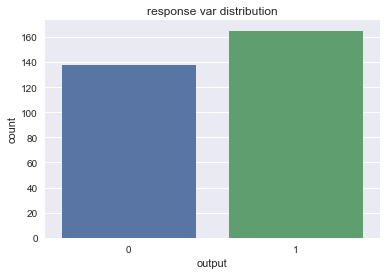

In [10]:
sns.countplot(x=df.output)
plt.title("response var distribution")
plt.show()

Seems like the repsonse classes distribution is quite balanced and doesn't require using methods such as over/under sampling and augmentation for imbalanced data.

Plot each feature's distribution to distinguish between categorical/binary/continous features, as each type requires different treatment in the preprocessing phase. I use *pandas_profiling.ProfileReport* which I find to be a really powerful EDA tool which grants a very extensive first glance at the data.

**Note**: ProfileReport generated a HTML page, which might not render when viewing the notebook on GitHub.

In [11]:
categorical = ['cp', 'restecg', 'caa', 'thall']
continous = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']

In [1]:
#ProfileReport(df)

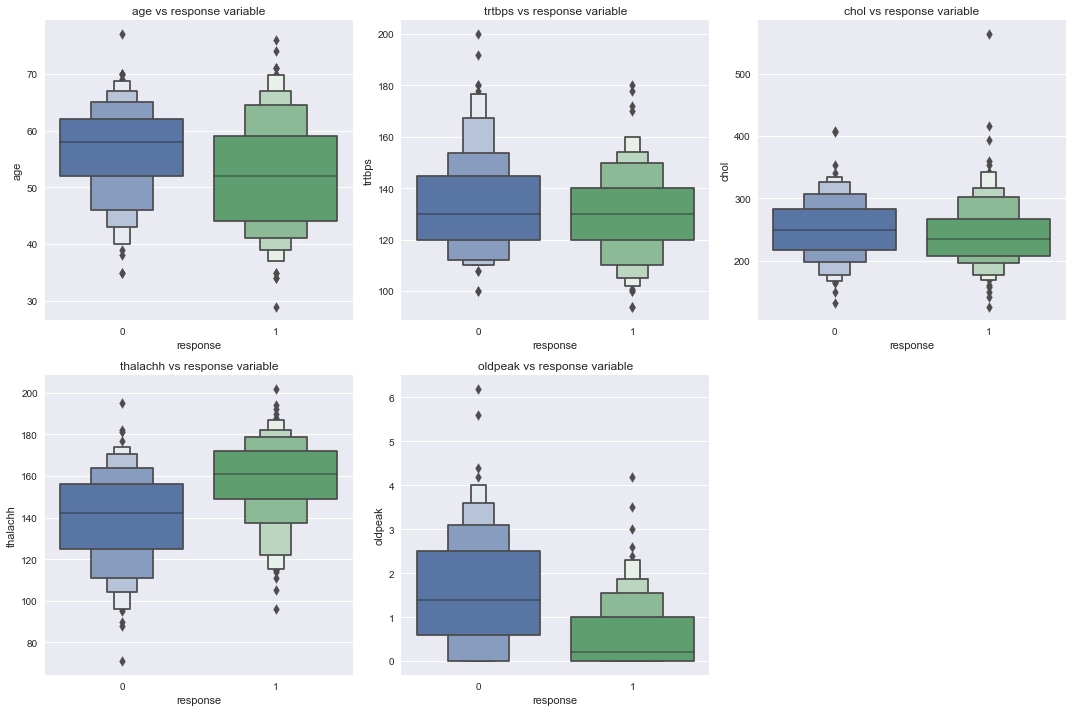

In [13]:
plt.figure(figsize=(15,10))

for i, cont in enumerate(continous):
    plt.subplot(2, 3, i+1)
    
    g = sns.boxenplot(x=df.output, y=df.loc[:, cont])
    g.set(title=f'{cont} vs response variable', xlabel='response')

plt.tight_layout()

### Notes about the data:

- No null values
- Reasonable amount of features, no need for decomposition. As part of the modelling strategy I will try regularized models (Lasso) to test the hypothesis of redundancy in the features. Might want to consider interactions if results aren't satisfying.
- High correlations between features (not to the point of redundancy), the logit model with $L_2$ penalty would shrink redundant features if such exist.
- 1 duplicate row - **drop**
- Outliers in the numeric variables, as can be seen in the boxenplot. Consider scaling method that will tend to that sensitivity (RobustScaler rather than StandardScaler)
- Split to continous, categorical and binary features (already happend)
- The target variable is quite balanced - no resampling is needed and can use accuracy as a score metric. 

Plot the distribution of the **continous** variables against the response:

## Data Preprocessing & Modelling

The overall strategy for this doodle is throwing various classifiers from different model families, testing each model's strength to classify the response correctly.

Since we will be dealing with models that have core differences between them, we need to preprocess the data such that the assumptions of each model about the features are satisfied. Some of the processes are shared, such as encoding the categorical variables.

For example, tree-based models are indifferent to scale, thus no need for feature scaling. Gradient-based models, such as GB, is in fact very dependant on scale. Distance-based models such as KNN depend on the unit of measure, hence one might want to normalize rather than scale.

That's why instead of seperating the preprocessing from the modelling, I packaged them together in a single process (pipe), from the raw (split) dataset to hyperparametrization to fitted models.

**Note**: when using one-hot-encoding I don't drop the first (last) category since I don't use non-regularized linear models.

In [14]:
# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# modelling
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import NotFittedError

In [15]:
def xy_generator(data, duplicates=None):
    """
    Create X, y arrays from a DataFrame. Allows for duplicate rows removal
    """
    if duplicates:
        data.drop(duplicates, axis=0, inplace=True)

    return {'X': data.iloc[:, :-1], 'y':  data.iloc[:, -1]}

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None) -> None:
        super().__init__()
        self.columns = columns
        self.n_features_in_ = None
        self.name_features_in_ = None
    
    def fit(self, X, y=None):
        self.n_features_in_ = len(X.columns.to_list())
        self.name_features_in_ = X.columns.to_list()
        return self

    def transform(self, X):
        cols_to_transform = None

        if self.columns:
            assert [col in self.name_features_in_ for col in self.columns], "passed columns not in X columns "
            cols_to_transform = self.columns

        return X.drop(cols_to_transform, axis=1)

In [16]:
xy = xy_generator(data=df, duplicates=[163])

X, y = xy['X'], xy['y']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [18]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(211, 13) (91, 13) (211,) (91,)


In [19]:
cat_transformer = make_pipeline(OneHotEncoder())
num_rob_transformer = make_pipeline(RobustScaler())
num_norm_transformer = make_pipeline(Normalizer())

pipelines = {
    'rf': make_pipeline(
        ColumnTransformer(transformers=[
            ("one_hot_encode", cat_transformer, categorical)
            ]),
        RandomForestClassifier(random_state=1234)
        ),
    'gb': make_pipeline(
        ColumnTransformer(transformers=[
            ("scaling", num_rob_transformer, continous),
            ("one_hot_encode",cat_transformer, categorical)
            ]),
        GradientBoostingClassifier(random_state=1234)
        ),
    'ridge': make_pipeline(
        ColumnTransformer(transformers=[
            ("scaling", num_rob_transformer, continous),
            ("one_hot_encode", cat_transformer, categorical)
            ]),
        RidgeClassifier(random_state=1234)
        ),
    'lasso': make_pipeline(
        ColumnTransformer(transformers=[
            ("scaling", num_rob_transformer, continous),
            ("one_hot_encode", cat_transformer, categorical)
            ]),
        LogisticRegression(random_state=1234)
        ),
    'knn': make_pipeline(
        ColumnTransformer(transformers=[
            ("normalizing", num_norm_transformer, continous),
            ("one_hot_encode", cat_transformer, categorical)
            ]),
        KNeighborsClassifier())
}

In [20]:
hypergrid = {
    'rf': {
        'randomforestclassifier__min_samples_split': [2, 4, 6, 8],
        'randomforestclassifier__min_samples_leaf': [1, 2, 3, 4, 5],
        'randomforestclassifier__n_estimators': [100, 200, 500]
    },
    'gb':{
        'gradientboostingclassifier__n_estimators': [100, 200, 500],
        "gradientboostingclassifier__max_leaf_nodes": [2, 5, 10, 20, 50, 100],
        'gradientboostingclassifier__learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01]
    },
    'ridge':{
        'ridgeclassifier__alpha': np.linspace(0, 1, 20)
    },
    'lasso':{
        'logisticregression__penalty': ['l1'], # want a Lasso classifier...
        'logisticregression__C' : np.logspace(0, 4, 20),
        'logisticregression__solver' : ['liblinear']
    },
    'knn':{
        'kneighborsclassifier__n_neighbors': [3, 4, 5, 6, 7]
    }
}

In [21]:
fit_models = {}

for algo, pipe in pipelines.items():
    model = GridSearchCV(pipe, hypergrid[algo], cv=5, n_jobs=-1)
    
    try:
        print(f'--- starting training for {algo} ---')
        model.fit(X_train, y_train)
        print(f'best score (accuracy): {round(model.best_score_, 2)}')
        print(f'n_features: {model.n_features_in_}')
        print(f'best params: {model.best_params_}')
        fit_models[algo] = model
        print(f'--- {algo} has been successfully fit --- \n')

    except NotFittedError as e:  # specific exception for sklearn models
        print(repr(e))

--- starting training for rf ---
best score (accuracy): 0.85
n_features: 13
best params: {'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__min_samples_split': 8, 'randomforestclassifier__n_estimators': 200}
--- rf has been successfully fit --- 

--- starting training for gb ---
best score (accuracy): 0.86
n_features: 13
best params: {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_leaf_nodes': 2, 'gradientboostingclassifier__n_estimators': 100}
--- gb has been successfully fit --- 

--- starting training for ridge ---
best score (accuracy): 0.85
n_features: 13
best params: {'ridgeclassifier__alpha': 0.631578947368421}
--- ridge has been successfully fit --- 

--- starting training for lasso ---
best score (accuracy): 0.86
n_features: 13
best params: {'logisticregression__C': 29.76351441631318, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
--- lasso has been successfully fit --- 

--- starting tr

**Note that the accuracy levels are not as high as one might expect, an indication for some bias in the data and perhaps for more training samples.**

## Evaluation

Since the classes of the response variable are quite balanced, accuracy is a fair evaluation metric for the classification. I added the F1 stat, which is the harmonic mean of precision & recall just in case.

In [22]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [23]:
scores_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

for algo, model in fit_models.items():
    y_pred = model.predict(X_test)
    
    acc = round(accuracy_score(y_test, y_pred), 2)
    pre = round(precision_score(y_test, y_pred), 2)
    rec = round(recall_score(y_test, y_pred), 2)
    f1 = round(f1_score(y_test, y_pred), 2)

    scores_df.loc[len(scores_df.index)] = [algo, acc, pre, rec, f1]

    print(f'{algo} scores: \n\
        Accuracy: {acc},\
        Precision: {pre},\
        Recall: {rec},\
        F1: {f1}'
    )

rf scores: 
        Accuracy: 0.8,        Precision: 0.81,        Recall: 0.84,        F1: 0.82
gb scores: 
        Accuracy: 0.79,        Precision: 0.78,        Recall: 0.86,        F1: 0.82
ridge scores: 
        Accuracy: 0.8,        Precision: 0.79,        Recall: 0.88,        F1: 0.83
lasso scores: 
        Accuracy: 0.8,        Precision: 0.8,        Recall: 0.86,        F1: 0.83
knn scores: 
        Accuracy: 0.76,        Precision: 0.79,        Recall: 0.76,        F1: 0.78


In [24]:
# Melt to long foramt
scores_long_format = pd.melt(scores_df, id_vars=['Model'], value_vars=['Accuracy', 'Precision', 'Recall', 'F1'])

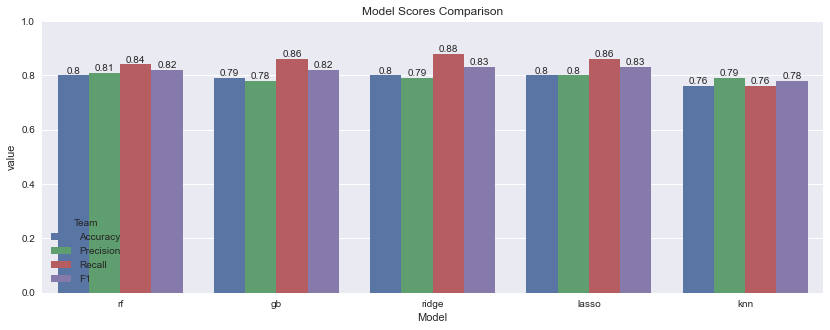

In [44]:
plt.figure(figsize=(14, 5))

g = sns.barplot(data=scores_long_format, x='Model', y='value', hue='variable')
g.set(title='Model Scores Comparison', ylim=(0, 1))

g.bar_label(g.containers[0])
g.bar_label(g.containers[1])
g.bar_label(g.containers[2])
g.bar_label(g.containers[3])
plt.legend(loc='lower left', title='Team')
plt.show(g)

### So which model to pick?

- Clearly KNN is the worst-performing model.
- Ridge & Lasso (logit with $L_1$ penalty) have the highest F1 score. Must be one of them.
- I tend to favor Recall rather than Precision as Recall (sensitivity) calculates the rate of the true positives out of all the real positives, while precision calculates the rate of the true positives out of all the predicted positives. 

In [37]:
best_model = fit_models['ridge']
y_pred = best_model.predict(X_test)

## Investigate and debug the model

Now that I have a decent baseline model, which was carefully trained with caring for splitting the dataset, encapsulating the fitting process in a pipeline to control for train/test leakage, cross-validation and evaluation with the appropriate metrics, I can focus on examining and debugging the model.

The tool for this is SHAP values, which is a great model-agnostic method performing ML explainability.

Note this won't be a proper process until we associate the (named) feature space and the post-transform encoded feature space. So need to extract the feature names from the transformers first.

In [40]:
import shap
plt.style.use('seaborn')

First, SHAP cannot handle sklearn pipeline objects, so need to extract both the estimator and the preprocessor from the pipeline and work with them separatley.

In [38]:
# fit the preprocessor 
cat_columns = list(best_model.best_estimator_.named_steps.columntransformer.named_transformers_.one_hot_encode.get_feature_names_out())
num_columns = list(best_model.best_estimator_.named_steps.columntransformer.named_transformers_.scaling.get_feature_names_out())
cols = [*num_columns, *cat_columns]

X_train_encoded = pd.DataFrame(best_model.best_estimator_['columntransformer'].fit_transform(X_train), columns=cols)
X_test_encoded = pd.DataFrame(best_model.best_estimator_['columntransformer'].transform(X_test), columns=cols)

# fit the model 
clf = best_model.best_estimator_['ridgeclassifier'].fit(X_train_encoded, y_train)

# calculate the Shap values
explainer = shap.Explainer(clf, X_test_encoded)
shap_values = explainer(X_test_encoded)
values = explainer.shap_values(X_test_encoded)

# print the JS visualization code to the notebook
shap.initjs()  

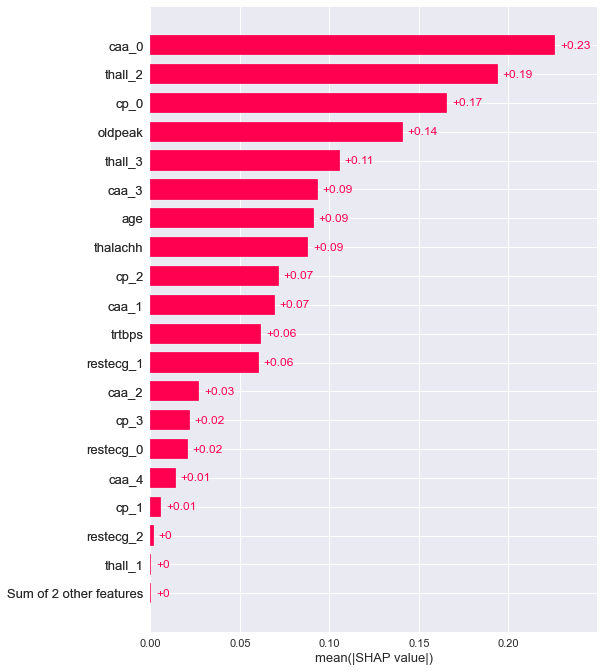

In [41]:
shap.plots.bar(shap_values, max_display=20)

Some features seem to not have an effect on the predictions. Having said that, the $L_1$ penalized which deals with those didn't perform better, and some of the non-parametric models such as RF and GB performed even worse, so might be better to just leave them.

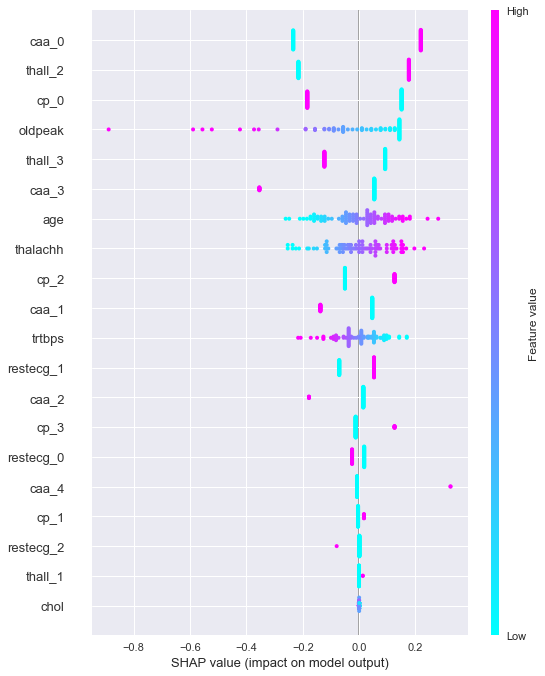

In [61]:
shap.summary_plot(shap_values, X_test_encoded, cmap='cool')

**Notes**:

- A nice take from this, relating to some of the notes taken from examining the data, is that `oldpeak`, which has significant sparseness, does impact the predictions in a meaningful way, including the 0 values.
- Note that for all the dummy variables, the regularized model was able to shrink the importance of one of the categories, thus avoiding any multicolinearity issues, which was expected.
- With regards to the numeric features, we see that the observed importance follows the expected pattern from the EDA (box plots). Especially `chol` which has the least importance overall.

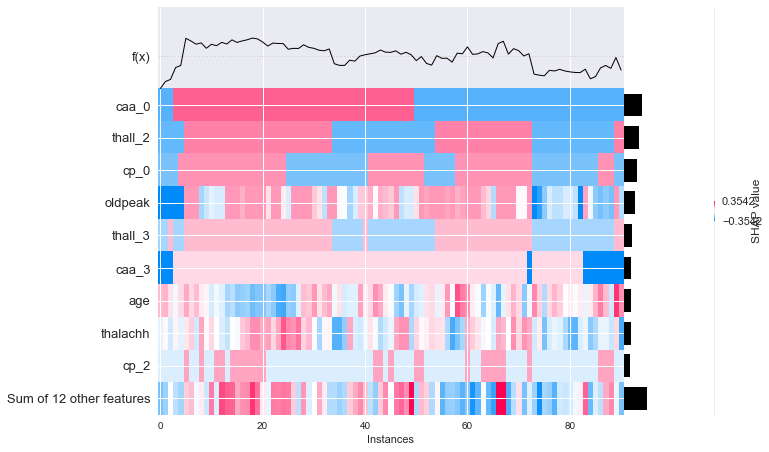

In [56]:
shap.plots.heatmap(shap_values, plot_width=15)

## Save best model for reuse

In [ ]:
import pickle

In [ ]:
# save the model as pickle
# with open('trained_models/heart_attack_model.pkl', 'wb') as f: 
#  pickle.dump(best_model, f)

In [ ]:
# reload the saved model
with open('trained_models/heart_attack_model.pkl', 'rb') as f: 
  reloaded_model = pickle.load(f)

In [45]:
reloaded_model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('scaling',
                                                                         Pipeline(steps=[('robustscaler',
                                                                                          RobustScaler())]),
                                                                         ['age',
                                                                          'trtbps',
                                                                          'chol',
                                                                          'thalachh',
                                                                          'oldpeak']),
                                                                        ('one_hot_encode',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder())]),
                                                                         ['cp',
                                                                          'restecg',
                                                                          'caa',
                                                                          'thall'])])),
                                       ('ridgeclassifier',
                                        RidgeClassifier(random_state=1234))]),
             n_jobs=-1,
             param_grid={'ridgeclassifier__alpha': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])})